### Convex Adjustment:Q Theory 
$$
V(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
s.t. \ A' = \rho A +\epsilon
$$
### Nonconvex Adjustment
$$
V(A,K)=\max_{0\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
s.t. \ A' = \rho A +\epsilon
$$
### Mixed model
$$
V^b(A,K)=\max_{(1-\delta)K\leq K'\leq AK^\alpha+(1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{K'-(1-\delta)K}{K})^2K-p(K'-(1-\delta)K)+\beta E_{A'|A}V(A',K')\}\\
V^s(A,K)=\max_{0\leq K'\leq (1-\delta)K}\{AK^\alpha-FK-\frac{\gamma}{2}(\frac{(1-\delta)K-K'}{K})^2K+p_s((1-\delta)K-K')+\beta E_{A'|A}V(A',K')\}\\
V^i(A,K)=AK^\alpha+\beta E_{A'|A}V(A',(1-\delta)K)\\
s.t. \ A' = \rho A +\epsilon
$$

In [1]:
from __future__ import division
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import fminbound
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import random as rd
from scipy.optimize import bisect
from mpl_toolkits.mplot3d import Axes3D
import pickle
%matplotlib notebook
import mpld3 
# import ipympl

In [2]:
class Investment(object):
    def __init__(self, beta=0.95, delta = 0.069, gamma = 0.043, alpha = 0.51,p = 1,F = 0.00039,ps = 0.967,
                     transition = [[.5,.5],[.5,.5]], shocks = [.9, 1.1],grid_max=50,
                     grid_min = .1, grid_size=200):

        self.delta, self.beta, self.gamma,self.alpha,self.p,self.F,self.ps = delta, beta, gamma,alpha,p,F,ps
        self.shocks = shocks
        self.transition = np.asarray(transition)

        self.grid = np.linspace(grid_min, grid_max, grid_size)

        if len(self.transition) != len(self.shocks):
            self.transition = [[1/len(self.shocks)]*len(self.shocks)]*len(self.shocks)

        for j in range(len(self.transition)):
            self.transition[j] = [max(k, 0) for k in self.transition[j]]
            self.transition[j] /= np.asarray(list(self.transition[j])).sum()
            if np.asarray(self.transition[j]).sum() == 0:
                self.transition[j] = np.asarray([1/len(self.transition)]*len(self.transition))
        self.transition = np.asarray(self.transition)

    def bellman_operator(self, w):

        Aw = [InterpolatedUnivariateSpline(self.grid, w[i]) for i in range(len(self.shocks))]
        Awx = lambda y: np.asarray([function(y) for function in Aw])
        sigma = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        Tw = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        flag = np.asarray([np.empty(len(w[0]))]*len(self.shocks))
        for i, x in enumerate(self.grid):
            for j, e in enumerate(self.shocks):
                buy = lambda k: -e*x**self.alpha+self.F*x+self.gamma*x*(k/x-1+self.delta)**2/2+self.p*(k-(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                sell = lambda k: -e*x**self.alpha+self.F*x+self.gamma*x*(-k/x+1-self.delta)**2/2-self.ps*(-k+(1-self.delta)*x)-self.beta*np.dot(self.transition[j],Awx(k))
                inaction = e*x**self.alpha+self.beta*np.dot(self.transition[j],Awx((1-self.delta)*x))
                b_star = fminbound(buy,(1-self.delta)*x,(1-self.delta)*x+e*x**self.alpha)
                s_star = fminbound(sell,0,(1-self.delta)*x)
                buy_max = -buy(b_star)
                sell_max = -sell(s_star)
                Tw[j][i] =  max(buy_max,sell_max,inaction)
                if Tw[j][i] == buy_max:
                    sigma[j][i] = b_star
                    flag[j][i] = 1
                elif Tw[j][i] == sell_max:
                    sigma[j][i] = s_star
                    flag[j][i] = -1
                else:
                    sigma[j][i] = (1-self.delta)*x
                    flag[j][i] = 0
        return Tw, sigma,flag
    
        
    
 

In [3]:
def approx_markov(rho, sigma_u, m, n):
        F = norm(loc=0, scale=sigma_u).cdf


        std_y = np.sqrt(sigma_u**2 / (1-rho**2))
        x_max = m * std_y
        x_min = - x_max
        x = np.linspace(x_min, x_max, n)

        step = (x_max - x_min) / (n - 1)
        half_step = 0.5 * step
        P = np.empty((n, n))

        for i in range(n):
            P[i, 0] = F(x[0]-rho * x[i] + half_step)
            P[i, n-1] = 1 - F(x[n-1] - rho * x[i] - half_step)
            for j in range(1, n-1):
                z = x[j] - rho * x[i]
                P[i, j] = F(z + half_step) - F(z - half_step)

        return x, P

In [4]:
def compute_fixed_point(T, v, error_tol=1e-3, max_iter=500,
                            print_skip=25,verbose=True):#迭代计算
        i = 0
        error = error_tol + 1

        while i < max_iter and error > error_tol:
            new_v = T(v)[0]
            i += 1
            error = np.max(np.abs(new_v - v))
            if verbose and i % print_skip == 0:
                print(f"第 {i}步收敛结果是  {error}.")
                
            v = new_v
        if i == max_iter:
            print("收敛失败")
        if verbose and i < max_iter:
            print(f"\n在第 {i} 步收敛")


        return v

In [5]:
epsilon, trans = approx_markov(rho = .106, sigma_u=.855, n = 20, m=1)
shocklist = np.exp(epsilon)

print(trans,shocklist)

[[0.1987386  0.03082771 0.03333827 0.0356519  0.03770162 0.0394253
  0.04076879 0.04168869 0.04215475 0.04215145 0.04167889 0.04075281
  0.03940368 0.03767503 0.03562118 0.03330432 0.03079149 0.02815131
  0.02545096 0.14472326]
 [0.19562393 0.03055287 0.03308029 0.03541802 0.03749876 0.03925974
  0.04064579 0.04161228 0.04212744 0.04217416 0.04175087 0.04087167
  0.03956553 0.0378747  0.03585249 0.03356039 0.03106508 0.02843516
  0.02573811 0.1472927 ]
 [0.19253909 0.03027668 0.03282017 0.03518125 0.03729231 0.03908995
  0.04051807 0.04153077 0.04209486 0.04219158 0.04181772 0.04098572
  0.03972304 0.03807064 0.03608076 0.03381417 0.03133716 0.02871827
  0.02602523 0.14989255]
 [0.18948416 0.0299992  0.032558   0.03494166 0.03708233 0.03891601
  0.04038567 0.04144422 0.04205701 0.0422037  0.0418794  0.04109491
  0.03987617 0.03826278 0.03630591 0.03406559 0.03160765 0.02900055
  0.02631225 0.15252281]
 [0.18645925 0.02972053 0.03229387 0.03469934 0.0368689  0.03873796
  0.04024863 0.04

In [6]:
%%time
cp = Investment(transition=trans,shocks=shocklist)
# w_guess = np.asarray([np.log(cp.grid)]*len(cp.shocks))
w_guess = np.zeros((len(cp.shocks),len(cp.grid)))
# w_guess

w_star = compute_fixed_point(cp.bellman_operator, w_guess, max_iter=500, verbose=1, error_tol=1e-2, print_skip=10)


In [7]:
# sigma_star = cp.bellman_operator(w_star)[1]
# flag_star = cp.bellman_operator(w_star)[2]


In [8]:
# test = r'3ddata.txt'
# with open(test,'wb') as f:
#     pickle.dump([w_star,sigma_star,flag_star],f) 

In [9]:
f = open('3ddata.txt', 'rb')
w_star,sigma_star,flag_star = pickle.load(f)

<IPython.core.display.Javascript object>


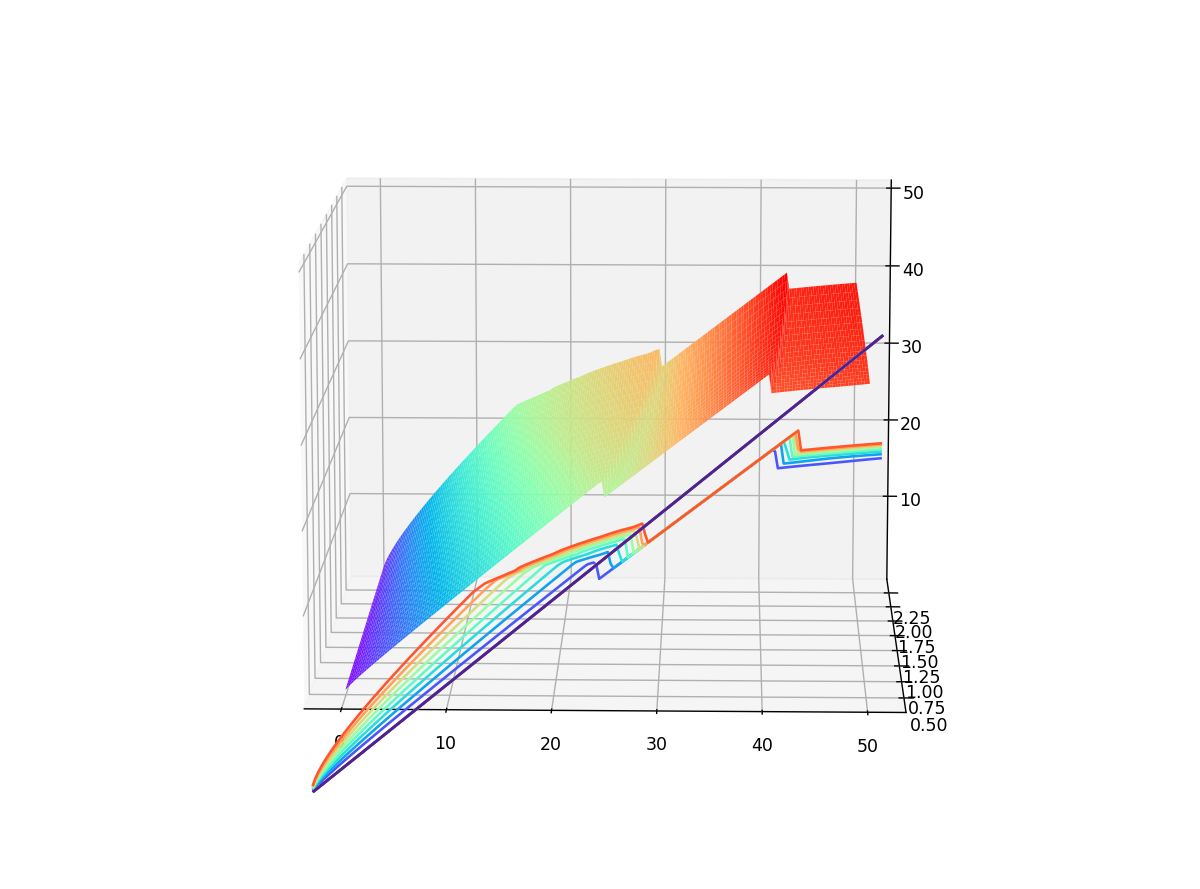

In [17]:

mpld3.enable_notebook()


cp = Investment(transition=trans,shocks=shocklist)
# fig, ax = plt.subplots(2, 1, figsize =(15,20))
# ax[0].set_xlabel("k")
# ax[1].set_xlabel("k")

# ax[0].set_ylabel("Value Function")
# ax[1].set_ylabel("k'(k)")
fig = plt.figure()  
ax = Axes3D(fig)  

xx = cp.grid
yy =  np.array(cp.shocks)
x, y = np.meshgrid(xx,yy)
z = x


ax.plot_surface(x,y, sigma_star, rstride=1, cstride=1, cmap='rainbow')  
ax.contour(x, y, sigma_star, zdir = 'y', offset = -1, cmap = plt.get_cmap('rainbow'))
ax.contour(x, y, z, zdir = 'y', offset = -1,cmap = plt.get_cmap('Purples'))
# ax.contour(x, y, z, zdir = 'x', offset = 0,cmap = plt.get_cmap('rainbow'))


# #         ax[0].set_prop_cycle(cycler('r', 'g', 'b', 'c', 'm', 'y')
# labels = [r'Shock {0:.2g}'.format(cp.shocks[k]) for k in range(len(cp.shocks))] # Label "Shock 1", "Shock 2"
# for i in range(len(cp.shocks)):
#     ax[0].plot(cp.grid, w_star[i], lw = 2, alpha = .8, label= labels[i])
# for i in range(len(cp.shocks)):
#     ax[1].plot(cp.grid, sigma_star[i], alpha = .8, lw = 2,  label= labels[i])

# ax[1].plot(cp.grid,cp.grid, alpha = .8, lw = 2,  label= "k' = k",linestyle=":")
# ax[1].plot(cp.grid,(1-cp.delta)*cp.grid, alpha = .8, lw = 2,  label= "k' = (1-delta)k",linestyle=":")

# ax[0].legend(loc = 'lower right')
# ax[1].legend(loc = 'lower right')

plt.show()